# AA Test

*Перед тем, как начать проводить AB-тесты, нужно обязательно пройти стадию АА-тестирования, чтобы убедиться в надежности и корректности нашей системы сплитования. Если система работает правильно, то все ключевые метрики не
должны отличаться между группами.*

**Задача** - провести AA-тест по данным с '2021-12-08' по '2021-12-14', пользователи из 2й и 3й экспериментальных групп.
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

**Ключевая метрика** - CTR.

In [1]:
# импортируем библиотеки
import pandas as pd
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from random import randint
from db.read_db import get_df
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_style("darkgrid", {"axes.facecolor": "lavender", 'axes.grid': False})

# достаем данные из БД для дальнейшего анализа
## открываем файл с запросом
with open('./db/aa_test.sql') as f:
    query = f.read()
## читаем данные из БД при помощи функции get_df()
df = get_df(query)

# сохраняем данные в csv (для личного репозитория с портфолио)
df.to_csv('~/ab_tests/data/aa_test_data.csv')

In [2]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.3056
1,3,123580,15,92,0.1630
2,2,131473,26,148,0.1757
3,2,23985,12,66,0.1818
4,2,24523,17,120,0.1417


Визуализируем распределение CTR по 2м экспериментальным группам:

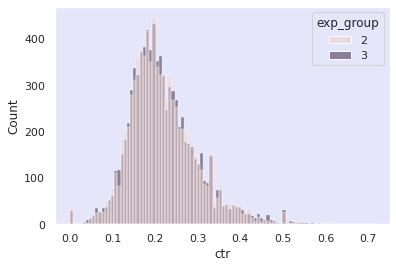

In [3]:
sns.histplot(data=df, x='ctr', hue='exp_group');

Распределения CTR в 2х контрольных группах визуально похожи, но при этом есть выбросы. </br>
Рассчитаем сглаженный CTR для контрольных групп.

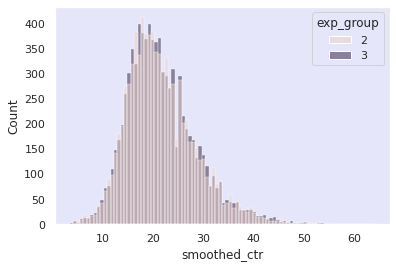

In [4]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    '''
    Функция рассчитывает сглаженный CTR.
    ---
    Параметры:
        user_likes -- количество лайков
        user_views -- количество просмотров
        global_ctr -- средний (глобальный) CTR до сглаживания
        alpha      -- значение штрафа
    
    '''
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha) * 100
    return smoothed_ctr

# сглаживаем CTR в экспериментальных группах
for exp_group in [2,3]:
    global_ctr = \
        df[df['exp_group']==exp_group]['likes'].sum() / \
        df[df['exp_group']==exp_group]['views'].sum() 
    
    df.loc[df['exp_group']==exp_group, 'smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr, 5), axis=1)

# визуализируем сглаженный CTR
sns.histplot(data=df, x='smoothed_ctr', hue='exp_group');

Распределения сглаженных CTR в 2х контрольных группах визуально похожи.
Проверим нулевую гипотезу о равенстве средних сглаженных CTR экспериментальных групп. Проведем сравнение средних сглаженных CTR в 2х контрольных группах t-testом (alpha=0.05).

In [5]:
exp_gr_1 = df.loc[df['exp_group']==2, 'smoothed_ctr'].values
exp_gr_2 = df.loc[df['exp_group']==3, 'smoothed_ctr'].values

stats.ttest_ind(exp_gr_1, exp_gr_2, equal_var=False)

Ttest_indResult(statistic=-0.6603141299293045, pvalue=0.5090611865557584)

Нулевую гипотезу отклонить не можем, p-value выше установленного alpha.

Проведем симуляцию из 10 000 АА-тестов, для каждого из которых:
- сформируем подвыборки с повторением из 500 пользователей из каждой эспериментальной группы;
- проведем сравнение этих подвыборок t-testом (по условию задания) и Mann-Whitney U test (дополнительно) при alpha=0.05. </br>
- нулевая гипотеза - равенство средних CTR экспериментальных групп. 

In [6]:
def run_t_test(df=df, metric='smoothed_ctr', exp_gr_1=2, exp_gr_2=3, num_experiments=10000, n_samples=500):
    '''
    Функция формирует подвыборки с повторением из указанного количества наблюдений
    из каждой эспериментальной группы, проводит сравнение этих подвыборок t-testом и возвращает p-values.
    ---
    Параметры:
        df               -- датафрейм
        metric           -- ключевая метрика, по которой ведем расчет
        exp_gr_1         -- номер (int) экспериментальной группы 1
        exp_gr_2         -- номер (int) экспериментальной группы 2
        num_experiments  -- количество экспериментов в симуляции
        n_samples        -- размер подвыборки    
    
    '''
    p_values = []
    exp_gr_1 = df.loc[df['exp_group']==exp_gr_1, metric]
    exp_gr_2 = df.loc[df['exp_group']==exp_gr_2, metric]
    
    for i in range(num_experiments):       
        sample_exp_gr_1 = exp_gr_1.sample(n=n_samples, replace=True).values        
        sample_exp_gr_2 = exp_gr_2.sample(n=n_samples, replace=True).values        
        p_value = stats.ttest_ind(sample_exp_gr_1, sample_exp_gr_2, equal_var=False).pvalue # Welch’s t-test     
        p_values.append(p_value)
    
    p_values_series = pd.Series(p_values)
    return p_values_series

def run_mu_test(df=df, metric='smoothed_ctr', exp_gr_1=2, exp_gr_2=3, num_experiments=10000, n_samples=500):
    '''
    Функция формирует подвыборки с повторением из указанного количества наблюдений
    из каждой эспериментальной группы, проводит сравнение этих подвыборок Mann-Whitney U test и возвращает p-values.
    ---
    Параметры:
        df               -- датафрейм
        metric           -- ключевая метрика, по которой ведем расчет
        exp_gr_1         -- номер (int) экспериментальной группы 1
        exp_gr_2         -- номер (int) экспериментальной группы 2
        num_experiments  -- количество экспериментов в симуляции
        n_samples        -- размер подвыборки    
    
    '''
    p_values = []
    exp_gr_1 = df.loc[df['exp_group']==exp_gr_1, metric]
    exp_gr_2 = df.loc[df['exp_group']==exp_gr_2, metric]
    
    for i in range(num_experiments):       
        sample_exp_gr_1 = exp_gr_1.sample(n=n_samples, replace=True).values        
        sample_exp_gr_2 = exp_gr_2.sample(n=n_samples, replace=True).values        
        p_value = stats.mannwhitneyu(sample_exp_gr_1, sample_exp_gr_2).pvalue     
        p_values.append(p_value)
    
    p_values_series = pd.Series(p_values)
    return p_values_series

Построим гистограмму распределения получившихся 10000 p-values и посчитаем, какой процент p values оказался меньше либо равен 0.05

t-test
В 5.45% случаях p-values оказался меньше либо равен 0.05


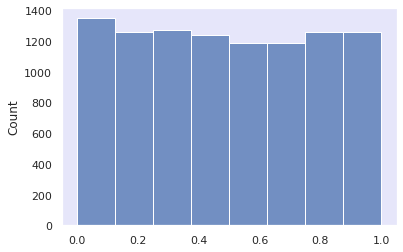

In [7]:
print('t-test')
results_t = run_t_test(df=df, metric='smoothed_ctr', exp_gr_1=2, exp_gr_2=3, num_experiments=10000, n_samples=500)
sns.histplot(results_t, bins=8);
share_t = results_t[results_t<0.05].shape[0] / results_t.shape[0] * 100
print(f'В {share_t:.2f}% случаях p-values оказался меньше либо равен 0.05')

Mann-Whitney U test
В 4.98% случаях p-values оказался меньше либо равен 0.05


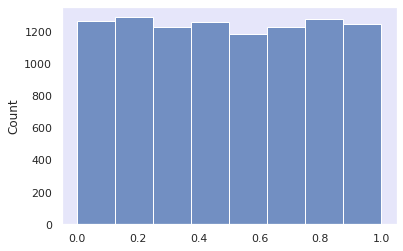

In [8]:
print('Mann-Whitney U test')
results_mu = run_mu_test(df=df, metric='smoothed_ctr', exp_gr_1=2, exp_gr_2=3, num_experiments=10000, n_samples=500)
sns.histplot(results_mu, bins=8);
share_mu = results_mu[results_mu<0.05].shape[0] / results_mu.shape[0] * 100
print(f'В {share_mu:.2f}% случаях p-values оказался меньше либо равен 0.05')

## Выводы:
- Распределение значений p-values равномерное;
- В ~5% случаях p-values оказался меньше либо равен 0.05.

На основании этого мы можем заключить, что наш АА-тест сошелся и что наша система сплитования работает корректно.